In [1]:
from pcb_envs import MultiPathGridEnv
from replay_buffers import PrioritizedReplayBuffer,  DRQN_ReplayBuffer
import numpy as np
import torch
import matplotlib.pyplot as plt
from drqn_agent import DRQNAgent
from rl_logger import ResultsLogger
#from agent_trainer import QLearner
from IPython.display import display, clear_output

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda')

## Env 1

In [4]:
n_agents = 3
grid_size = [15,10]
obs_size = [7,7]
obstacles = [(3,3),(6,2), (6,3), (9,4), (9,3), (10,4), (8,9), (8,8)]
starts = [(13,9), (8,5), (6,4)]
goals = [(2,4), (4,9), (9,8)] # orig: (2,1) 
to_train = True   

In [5]:
env1 = MultiPathGridEnv(obstacles, starts, goals, grid_size=grid_size, obs_size = [7,7], agents_n=n_agents, train=to_train, in_place=True) 

In [6]:
state = env1.reset()

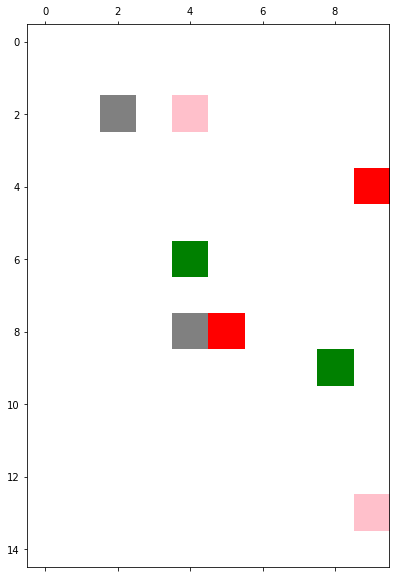

In [7]:
env1.render()

In [8]:
state

[(array([[[  0.,   0.,   0.,   0., -10., -10., -10.],
          [  0.,   0.,   0.,   0., -10., -10., -10.],
          [  0.,   0.,   0.,   0., -10., -10., -10.],
          [  0.,   0.,   0.,  13., -10., -10., -10.],
          [  0.,   0.,   0.,   0., -10., -10., -10.],
          [-10., -10., -10., -10., -10., -10., -10.],
          [-10., -10., -10., -10., -10., -10., -10.]]]),
  12.083045973594572),
 (array([[[  0.,   0.,   0.,   0.,   0.,   0.,   0.],
          [  0.,   0.,  33.,   0.,   0.,   0.,   0.],
          [  0.,   0.,   0.,   0.,   0.,   0.,   0.],
          [  0.,   0., -10.,  23.,   0.,   0.,   0.],
          [  0.,   0.,   0.,   0.,   0.,   0.,  36.],
          [  0.,   0.,   0.,   0.,   0.,   0.,   0.],
          [  0.,   0.,   0.,   0.,   0.,   0.,   0.]]]),
  5.656854249492381),
 (array([[[  0.,   0.,   0.,   0.,   0.,   0.,   0.],
          [  0.,   0.,   0.,   0.,   0.,   0.,   0.],
          [  0.,   0.,   0.,   0.,   0.,   0.,   0.],
          [  0.,   0.,   0.,  3

# DQN

In [9]:
state_dim = grid_size[0]*grid_size[1]
action_dim = 8

### Training

In [10]:
dqn_agents = []
for i in range(n_agents):
    dqn_agents.append(DRQNAgent(action_dim, DRQN_ReplayBuffer(100), device))

In [11]:
reward_sums_list = []
epsilon_history = []
remainin_on_termination = []

In [12]:
def train_agent(agents):
    TARGET_UPDATE = 4
    N = 50000
    max_time_steps = 3000
    epsilon = 0.9
    decay = 0.9999
    min_epsilon = 0.1
    agents_set = set(range(0,n_agents))
    for episode in range(N):
        reward_sum = 0 
        state = env1.reset()
        epsilon = max(min_epsilon, epsilon*decay)
        epsilon_history.append(epsilon)
        terminated_indices = []
        episode_experience = [[] for agent in agents]
        for i in range(max_time_steps):
            remaining_agents = agents_set - set(terminated_indices)
            chosen_actions = []
            for i, a_id in enumerate(remaining_agents):
                t_state = (torch.from_numpy(state[i][0]).float().unsqueeze(0).to(device),torch.Tensor([state[i][1]]).to(device))
                action = agents[a_id].epsilon_greedy_action(t_state, epsilon)
                chosen_actions.append(action)
            next_state, reward, terminal = env1.step(chosen_actions, remaining_agents)
            for i, a_id in enumerate(remaining_agents):
                episode_experience[a_id].append((state[i], next_state[i], [chosen_actions[i]], [np.mean(reward)]))
            reward_sum += np.mean(reward) 
            state = next_state 
            #env1.render()  
            if all(terminal):
                clear_output(wait=False)
                display('Episode {0} ended with {1} agents remaining'.format(str(episode), remaining_agents))
                remainin_on_termination.append(len(remaining_agents))
                reward_sums_list.append(reward_sum)
                reward_sum = 0
                break
            else:
                terminal = np.array(terminal)
                remaining_terminal = np.delete(terminal, terminated_indices)
                terminated_indices = terminal.nonzero()[0]
                idx_remove = remaining_terminal.nonzero()[0]
                if idx_remove.any():
                    for idx in sorted(idx_remove, reverse=True): 
                        del state[idx]
                            
        for i, agent in enumerate(agents): 
            agent.memory.add_to_buffer(episode_experience[i])
            if episode !=0:
                agent.update(2, 20)

In [ ]:
train_agent(dqn_agents)

'Episode 7024 ended with {0, 1, 2} agents remaining'

In [ ]:
dqn_agents[2].memory.buffer

## Visualise training 

In [ ]:
mse_history = dqn_agents[1].network_loss_history

In [ ]:
results_log = ResultsLogger(reward_sums_list, epsilon_history, mse_history)

In [ ]:
results_log.write_rewards(file_name="learning_history.csv")

In [ ]:
results_log.viz_rewards(cumsum_n=1000)

In [ ]:
results_log.rewards_stats()

In [ ]:
def viz_mse(mse_history, cumsum_n, color):
    cumsum_vec = np.cumsum(np.insert(mse_history, 0, 0)) 
    ma_vec = (cumsum_vec[cumsum_n:] - cumsum_vec[:-cumsum_n]) / cumsum_n 
    return plt.plot(range(0,len(ma_vec)), ma_vec, color)      

In [ ]:
import matplotlib.patches as mpatches

In [ ]:
colors = ['pink','red','green']
plt.figure(figsize=(12,8))
for n in range(0,n_agents):
    mse_hist = dqn_agents[n].network_loss_history
    plot = viz_mse(mse_hist, 1000, colors[n])
agent1_label = mpatches.Patch(color='pink', label='Agent 1')
agent2_label = mpatches.Patch(color='red', label='Agent 2')
agent3_label = mpatches.Patch(color='green', label='Agent 3')
plt.legend(handles=[agent1_label, agent2_label, agent3_label])
#plt.legend(handles=[red_patch])
#plt.legend(handles=[red_patch])
plt.show()

In [ ]:
fig, ax1 = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(8)
cumsum_vec = np.cumsum(np.insert(remainin_on_termination, 0, 0)) 
ma_vec = (cumsum_vec[1:] - cumsum_vec[:-1]) / 1 # <<-- 100 instead of 5
ax1.plot(range(0,len(ma_vec)), ma_vec)

## Learnt Policy 

In [ ]:
def test_policy(agents):
    max_time_steps = 3000
    epsilon = 0.9
    decay = 0.9999
    min_epsilon = 0.1
    agents_set = set(range(0,n_agents))
    reward_sum = 0
    state = env1.reset()
    epsilon = max(min_epsilon, epsilon*decay)
    epsilon_history.append(epsilon)
    terminated_indices = []
    for i in range(max_time_steps):
        remaining_agents = agents_set - set(terminated_indices)
        chosen_actions = []
        for i, a_id in enumerate(remaining_agents):
            t_state = (torch.from_numpy(state[i][0]).float().unsqueeze(0).to(device),torch.Tensor([state[i][1]]).to(device))
            action = agents[a_id].policy_action(t_state)
            chosen_actions.append(action)
            if type(action) is not list:
                action = [action]
        next_state, reward, terminal = env1.step(chosen_actions, remaining_agents)
        print("Reward is: ", reward)
        reward_sum += np.mean(reward) # 
        state = next_state 
        env1.render()  
        if all(terminal):
            remainin_on_termination.append(len(remaining_agents))
            reward_sums_list.append(reward_sum)
            break
        else:
            terminal = np.array(terminal)
            remaining_terminal = np.delete(terminal, terminated_indices)
            terminated_indices = terminal.nonzero()[0]
            idx_remove = remaining_terminal.nonzero()[0]
            if idx_remove.any():
                for idx in sorted(idx_remove, reverse=True): 
                    del state[idx]
    print("Reward sum is: ", reward_sum)

In [ ]:
test_policy(dqn_agents) 

In [ ]:
state

## Interpratability test 

In [ ]:
env1.reset()
env1.step([0], [0])
state = env1.step([0], [0])[0][0]
t_state = (torch.from_numpy(state[0]).reshape(1,1,obs_size[0],obs_size[1]).float().to(device),torch.Tensor([state[1]]).to(device))

In [ ]:
state

In [ ]:
dqn_agents[0].qnet(t_state)

In [ ]:
env1.render()

## Save model parameters 

In [ ]:
!ls

In [ ]:
torch.save(dqn_agents[0].qnet.state_dict(), 'models/drqn-dist-agent1.pth')

In [ ]:
torch.save(dqn_agents[1].qnet.state_dict(), 'models/drqn-dist-agent2.pt')

In [ ]:
torch.save(dqn_agents[2].qnet.state_dict(), 'models/drqn-dist-agent3.pt')